# Cell 0: Feature Extraction from Audio Files
This cell defines functions to extract features from audio files and processes the RAVDESS dataset to create a feature DataFrame. The features are saved to a CSV file.

In [1]:
import os
import librosa
import numpy as np
import pandas as pd

# Function to extract emotion from the filename with error handling
def extract_emotion_from_filename(filename):
    try:
        # The emotion code is the third part in the filename (e.g., "03-01-06-01-02-01-12.wav" -> "03")
        emotion_code = filename.split('-')[2]
        
        # Mapping emotion codes to emotion labels
        emotion_mapping = {
            '01': 'Neutral',
            '02': 'Calm',
            '03': 'Happy',
            '04': 'Sad',
            '05': 'Angry',
            '06': 'Fearful',
            '07': 'Disgust',
            '08': 'Surprised'
        }
        
        return emotion_mapping.get(emotion_code, 'Unknown')  # Return "Unknown" if no match is found
    except IndexError:
        print(f"Error: Filename {filename} does not match expected format. Setting emotion to 'Unknown'.")
        return 'Unknown'  # In case of error, return 'Unknown'

# Function to extract all features from an audio file
def extract_features_from_audio(audio_path, filename):
    y, sr = librosa.load(audio_path, sr=48000)  # Ensure consistent sampling rate
    
    # Extract MFCCs (13 MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)  # Mean of MFCCs across time
    
    # Extract Pitch (Fundamental Frequency)
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch[pitch > 0]) if pitch.size > 0 else 0  # Mean pitch (avoid errors for silent sections)
    
    # Extract Energy (Root Mean Square Energy)
    rmse = librosa.feature.rms(y=y)
    rmse_mean = np.mean(rmse)  # Mean energy
    
    # Extract Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=y)
    zcr_mean = np.mean(zcr)  # Mean Zero-Crossing Rate
    
    # Extract Spectral Roll-off
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
    spectral_rolloff_mean = np.mean(spectral_rolloff)  # Mean Spectral Roll-off
    
    # Extract Chromagram (12 chroma features)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)  # Mean of chroma features
    
    # Extract Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)  # Mean Spectral Centroid
    
    # Extract Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)  # Mean Spectral Bandwidth
    
    # Extract Tempo (beats per minute)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    
    # Extract Tonnetz (5 features)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    tonnetz_mean = np.mean(tonnetz, axis=1)  # Mean of Tonnetz features
    
    # Get the emotion label from the filename
    emotion = extract_emotion_from_filename(filename)
    
    # Return the features along with the emotion label
    return np.hstack([mfccs_mean, pitch_mean, rmse_mean, zcr_mean, spectral_rolloff_mean, 
                      chroma_mean, spectral_centroid_mean, spectral_bandwidth_mean, 
                      tempo, tonnetz_mean]), emotion

# Path to the RAVDESS dataset folder
ravdess_folder = '/Users/eliasskau/Artificial Intelligence/Audio-data'  # Update with actual path

# List to store the features
audio_features = []

# Loop through all Actor folders and extract features (excluding custom_audio folder)
for actor_folder in os.listdir(ravdess_folder):
    if 'Actor_' in actor_folder:  # Ensure we only process folders named Actor_XX
        actor_path = os.path.join(ravdess_folder, actor_folder)
        if os.path.isdir(actor_path):  # Process only folders (Actor_01, Actor_02, ...)
            for audio_file in os.listdir(actor_path):
                if audio_file.endswith(".wav"):  # Process only .wav files
                    audio_path = os.path.join(actor_path, audio_file)
                    
                    # Extract features for the audio file and get emotion from filename
                    features, emotion = extract_features_from_audio(audio_path, audio_file)
                    
                    # Store the features along with the emotion label
                    audio_features.append(np.append(features, emotion))

# Correct the columns for Tonnetz features (add 'Emotion' column)
feature_columns = [f"MFCC_{i+1}" for i in range(13)] + ['Pitch', 'Energy', 'ZCR', 'Spectral_Rolloff', 
                                                    'Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 
                                                    'Chroma_6', 'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 
                                                    'Chroma_11', 'Chroma_12', 'Spectral_Centroid', 'Spectral_Bandwidth', 
                                                    'Tempo', 'Tonnetz_1', 'Tonnetz_2', 'Tonnetz_3', 'Tonnetz_4', 'Tonnetz_5', 'Tonnetz_6', 
                                                    'Emotion']

# Convert the features into a DataFrame
features_df = pd.DataFrame(audio_features, columns=feature_columns)

# Save the features DataFrame to a CSV file
features_df.to_csv("ravdess_audio_features_all.csv", index=False)
print("Feature extraction complete. Saved to 'ravdess_audio_features_all.csv'.")

print(feature_columns)


Feature extraction complete. Saved to 'ravdess_audio_features_all.csv'.
['MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'Pitch', 'Energy', 'ZCR', 'Spectral_Rolloff', 'Chroma_1', 'Chroma_2', 'Chroma_3', 'Chroma_4', 'Chroma_5', 'Chroma_6', 'Chroma_7', 'Chroma_8', 'Chroma_9', 'Chroma_10', 'Chroma_11', 'Chroma_12', 'Spectral_Centroid', 'Spectral_Bandwidth', 'Tempo', 'Tonnetz_1', 'Tonnetz_2', 'Tonnetz_3', 'Tonnetz_4', 'Tonnetz_5', 'Tonnetz_6', 'Emotion']


# Cell 1: Random Forest Training and Feature Importance
This cell loads the feature data, trains a Random Forest classifier, and calculates feature importance. It also visualizes the feature importance and evaluates the model's accuracy.

Unique emotion labels in the dataset:
['Angry' 'Fearful' 'Disgust' 'Sad' 'Surprised' 'Happy' 'Calm' 'Neutral']
Feature Importance:
               Feature  Importance
14              Energy    0.063533
0               MFCC_1    0.048176
2               MFCC_3    0.038040
5               MFCC_6    0.036104
3               MFCC_4    0.034573
8               MFCC_9    0.034248
1               MFCC_2    0.031783
6               MFCC_7    0.030353
4               MFCC_5    0.029699
15                 ZCR    0.029155
12             MFCC_13    0.028251
9              MFCC_10    0.027809
7               MFCC_8    0.027319
10             MFCC_11    0.026931
30  Spectral_Bandwidth    0.026043
11             MFCC_12    0.025210
13               Pitch    0.024822
16    Spectral_Rolloff    0.024209
36           Tonnetz_5    0.023080
21            Chroma_5    0.022957
35           Tonnetz_4    0.022390
22            Chroma_6    0.022106
28           Chroma_12    0.021796
20            Chroma_4    0.0

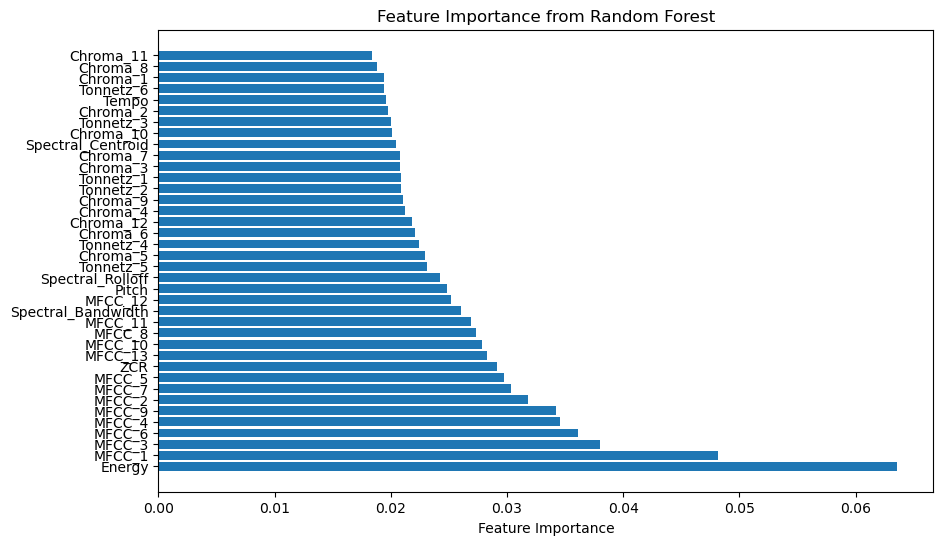

Test Accuracy: 57.29%


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the updated CSV file that includes emotion labels
data = pd.read_csv("ravdess_audio_features_all.csv")  # Adjust the file path as needed

# Ensure that the 'Emotion' column contains the correct emotion labels
print("Unique emotion labels in the dataset:")
print(data['Emotion'].unique())  # Print unique emotion labels to check

# Separate features (X) and target labels (y)
X = data.drop(columns=["Emotion"])  # Features (all columns except 'Emotion')
y = data["Emotion"]  # Target variable (Emotion)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a RandomForestClassifier with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model using the training data
rf.fit(X_train, y_train)

# Get the feature importances from the trained Random Forest model
importances = rf.feature_importances_

# Create a DataFrame to display the features and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print("Feature Importance:")
print(feature_importance_df)

# Visualize the feature importances in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

# Evaluate the model on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy on the test set
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")



# Cell 2: Fine-Grained Feature Selection
This cell explores the effect of different feature importance thresholds on model accuracy using finer increments. It plots the accuracy curve for various thresholds.

Unique emotion labels in the dataset:
['Angry' 'Fearful' 'Disgust' 'Sad' 'Surprised' 'Happy' 'Calm' 'Neutral']
Feature Importance:
               Feature  Importance
14              Energy    0.063974
0               MFCC_1    0.052371
2               MFCC_3    0.037153
3               MFCC_4    0.035015
5               MFCC_6    0.034345
1               MFCC_2    0.033788
8               MFCC_9    0.033670
4               MFCC_5    0.031265
9              MFCC_10    0.030595
12             MFCC_13    0.029410
15                 ZCR    0.028527
6               MFCC_7    0.027964
7               MFCC_8    0.027279
11             MFCC_12    0.026317
10             MFCC_11    0.026260
13               Pitch    0.024716
16    Spectral_Rolloff    0.024432
30  Spectral_Bandwidth    0.023451
32           Tonnetz_1    0.022917
33           Tonnetz_2    0.021862
29   Spectral_Centroid    0.021758
21            Chroma_5    0.021753
25            Chroma_9    0.021631
35           Tonnetz_4    0.0

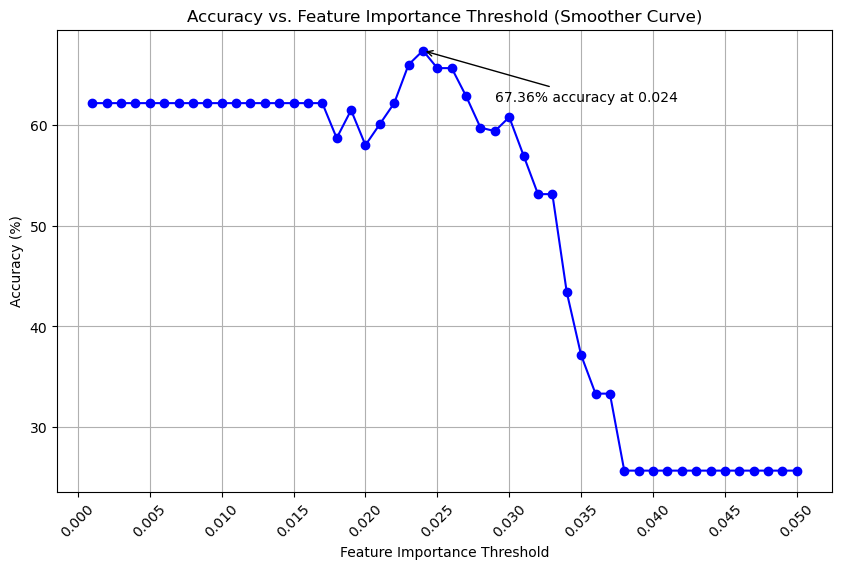

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the updated CSV file that includes emotion labels
data = pd.read_csv("ravdess_audio_features_all.csv")  # Adjust the file path as needed

# Ensure that the 'Emotion' column contains the correct emotion labels
print("Unique emotion labels in the dataset:")
print(data['Emotion'].unique())  # Print unique emotion labels to check

# Separate features (X) and target labels (y)
X = data.drop(columns=["Emotion"])  # Features
y = data["Emotion"]  # Target variable (Emotion)

# Train RandomForest to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print("Feature Importance:")
print(feature_importance_df)

# Adjusting the cutoff thresholds to use finer increments for a smoother curve (0.01, 0.02, ..., 0.1)
thresholds_fine = np.arange(0.001, 0.051, 0.001) #Create finer increments from 1% to 10%
accuracies_fine = []  # Store accuracy for each threshold

# Loop over each threshold and calculate accuracy
for threshold in thresholds_fine:
    selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']
    
    # Select only the important features
    X_selected = X[selected_features]
    
    # Check if X_selected is empty
    if X_selected.empty:
        print(f"No features selected for threshold {threshold}. Skipping this iteration.")
        accuracies_fine.append(0)  # Append 0 accuracy for this threshold
        continue
    
    # Split data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Train the model on the selected features
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf.predict(X_test)

    # Calculate accuracy on the test set
    accuracy = np.mean(y_pred == y_test) * 100
    accuracies_fine.append(accuracy)

# Plot the accuracy curve with smaller increments
plt.figure(figsize=(10, 6))
plt.plot(thresholds_fine, accuracies_fine, marker='o', linestyle='-', color='b')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Feature Importance Threshold (Smoother Curve)')
plt.xticks(np.arange(0, 0.051, 0.005), [f'{t:.3f}' for t in np.arange(0, 0.051, 0.005)], rotation=45)

# Annotate the highest value on the x-axis
max_accuracy_index = np.argmax(accuracies_fine)
max_threshold = thresholds_fine[max_accuracy_index]
max_accuracy = accuracies_fine[max_accuracy_index]
plt.annotate(f'{max_accuracy:.2f}% accuracy at {max_threshold:.3f}', 
             xy=(max_threshold, max_accuracy), 
             xytext=(max_threshold + 0.005, max_accuracy - 5),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)
plt.grid(True)
plt.show()


# Cell 3: Model Evaluation with Selected Features
This cell applies a specific feature importance threshold, trains the model with selected features, and evaluates its performance using a confusion matrix and classification report.

Test Accuracy (with 2.4% cutoff): 67.36%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.77      0.75      0.76        36
        Calm       0.62      0.89      0.73        44
     Disgust       0.63      0.74      0.68        39
     Fearful       0.68      0.50      0.58        34
       Happy       0.70      0.68      0.69        41
     Neutral       0.70      0.35      0.47        20
         Sad       0.72      0.53      0.61        34
   Surprised       0.66      0.72      0.69        40

    accuracy                           0.67       288
   macro avg       0.69      0.65      0.65       288
weighted avg       0.68      0.67      0.67       288



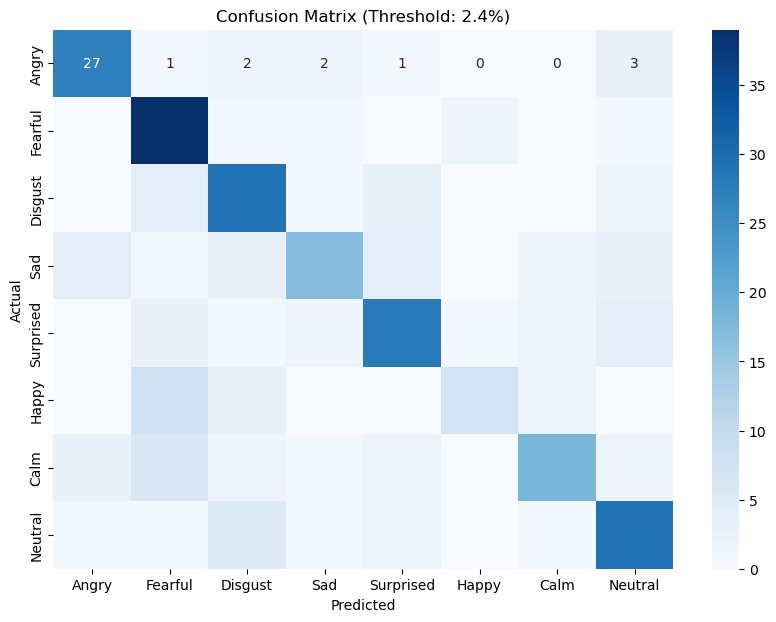

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the updated CSV file that includes emotion labels
data = pd.read_csv("ravdess_audio_features_all.csv")  # Adjust the file path as needed

# Separate features (X) and target labels (y)
X = data.drop(columns=["Emotion"])  # Features
y = data["Emotion"]  # Target variable (Emotion)

# Train RandomForest to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Apply the threshold of 0.024
threshold = 0.024
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

# Select only the important features
X_selected = X[selected_features]

# Check if X_selected is empty
if X_selected.empty:
    print(f"No features selected for threshold {threshold}. Skipping this iteration.")
else:
    # Split data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Train the model on the selected features
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf.predict(X_test)

    # Calculate accuracy on the test set
    accuracy = np.mean(y_pred == y_test) * 100
    print(f"Test Accuracy (with {threshold*100}% cutoff): {accuracy:.2f}%")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Threshold: {threshold*100}%)')
    plt.show()


# Cell 4: Final Feature Selection
This cell prints the final list of features selected after applying the chosen feature importance threshold.

In [53]:
# Apply the 2.4% threshold (0.024)
threshold = 0.024  # 2.4% threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature']

# Print the final list of features included after the threshold
print(f"Features selected after applying {threshold*100}% importance cutoff:")
print(selected_features.tolist())
print(f"Number of features selected: {len(selected_features)}")


Features selected after applying 2.4% importance cutoff:
['Energy', 'MFCC_1', 'MFCC_3', 'MFCC_4', 'MFCC_6', 'MFCC_2', 'MFCC_9', 'MFCC_5', 'MFCC_10', 'MFCC_13', 'ZCR', 'MFCC_7', 'MFCC_8', 'MFCC_12', 'MFCC_11', 'Pitch', 'Spectral_Rolloff']
Number of features selected: 17


# Cell 5: PCA for Dimensionality Reduction
This cell applies PCA to reduce the dimensionality of the selected features while retaining 95% of the variance. It trains a Random Forest model on the reduced features and evaluates its performance.

Number of components after PCA: 16
Test Accuracy (after PCA): 62.15%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.75      0.75      0.75        36
        Calm       0.67      0.80      0.73        44
     Disgust       0.57      0.67      0.61        39
     Fearful       0.55      0.62      0.58        34
       Happy       0.73      0.54      0.62        41
     Neutral       0.56      0.25      0.34        20
         Sad       0.53      0.59      0.56        34
   Surprised       0.59      0.57      0.58        40

    accuracy                           0.62       288
   macro avg       0.62      0.60      0.60       288
weighted avg       0.63      0.62      0.62       288



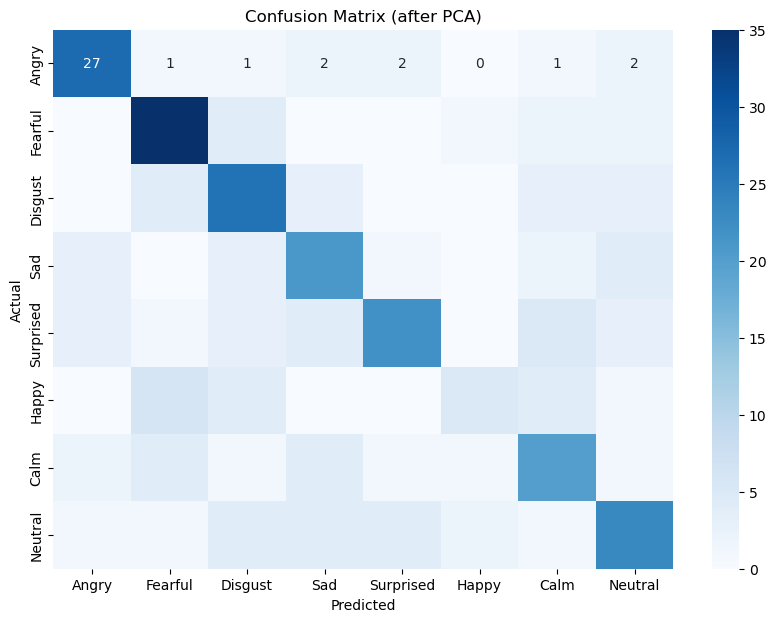

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the selected features are already available in X_selected
# Standardize the data (important for PCA)
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

# Apply PCA
pca = PCA(n_components=0.99)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_selected_scaled)

# Check how many components are used after PCA
print(f"Number of components after PCA: {X_pca.shape[1]}")

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train the model on the reduced features (after PCA)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)

# Calculate accuracy on the test set
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy (after PCA): {accuracy:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (after PCA)')
plt.show()


# Cell 6: PCA Explained Variance
This cell prints the explained variance ratio for each PCA component and the total variance explained by the selected components.

In [54]:
# Print explained variance ratio
print(f"Explained variance ratio per component: {pca.explained_variance_ratio_}")

# Print total explained variance by the selected components
print(f"Total explained variance by {X_pca.shape[1]} components: {np.sum(pca.explained_variance_ratio_):.4f}")


Explained variance ratio per component: [0.49082459 0.10060612 0.0733072  0.06273687 0.05077995 0.04678885
 0.03334369 0.02837337 0.02416483 0.01973444 0.01538718 0.01221   ]
Total explained variance by 12 components: 0.9583


# Cell 7: PCA on All 38 Features
This cell applies PCA to the full dataset (all features) to retain 95% of the variance. It trains a Random Forest model on the reduced features and evaluates its performance.

Number of components after PCA: 21
Test Accuracy (after PCA with 38 features): 47.92%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.61      0.69      0.65        36
        Calm       0.49      0.66      0.56        44
     Disgust       0.45      0.44      0.44        39
     Fearful       0.52      0.47      0.49        34
       Happy       0.42      0.46      0.44        41
     Neutral       0.29      0.10      0.15        20
         Sad       0.40      0.35      0.38        34
   Surprised       0.49      0.45      0.47        40

    accuracy                           0.48       288
   macro avg       0.46      0.45      0.45       288
weighted avg       0.47      0.48      0.47       288



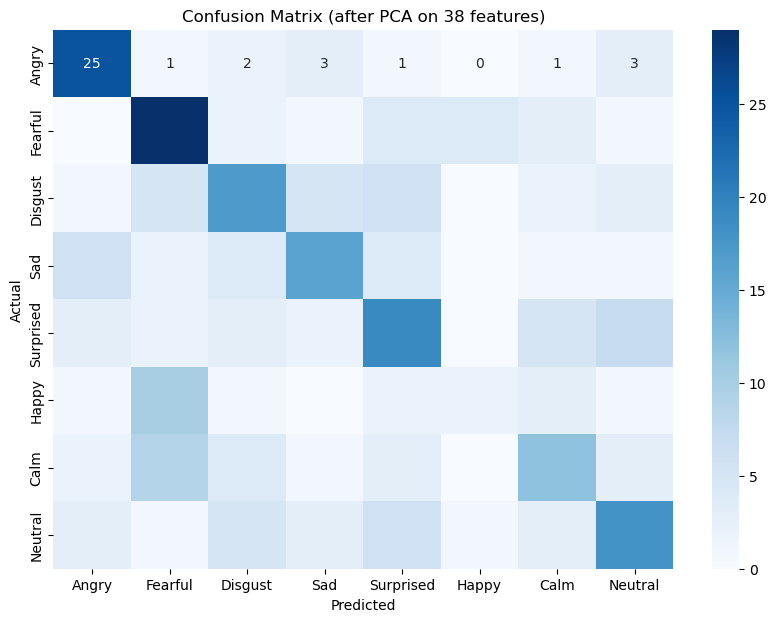

In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the full data from the updated CSV file (38 features)
data = pd.read_csv("ravdess_audio_features_all.csv")  # Adjust the file path if needed

# Separate features (X) and target labels (y)
X = data.drop(columns=["Emotion"])  # Features (all 38 columns except 'Emotion')
y = data["Emotion"]  # Target variable (Emotion)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to the full 38 features
pca = PCA(n_components=0.95)  # Retaining 95% variance
X_pca = pca.fit_transform(X_scaled)

# Check how many components are used after PCA
print(f"Number of components after PCA: {X_pca.shape[1]}")

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train the model using RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)

# Calculate accuracy on the test set
accuracy = np.mean(y_pred == y_test) * 100
print(f"Test Accuracy (after PCA with 38 features): {accuracy:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (after PCA on 38 features)')
plt.show()


# Cell 9: Saving New features to a csv file

In [59]:
import pandas as pd

# Assuming you have already selected 17 features based on the feature importance analysis
selected_features = ['Energy', 'MFCC_1', 'MFCC_3', 'MFCC_4', 'MFCC_6', 'MFCC_2', 'MFCC_9', 'MFCC_5', 'MFCC_10', 'MFCC_13', 'ZCR', 'MFCC_7', 'MFCC_8', 'MFCC_12', 'MFCC_11', 'Pitch', 'Spectral_Rolloff']   # Replace with the actual feature names

# Load the original dataset (the CSV with all features and labels)
data = pd.read_csv("ravdess_audio_features_all.csv")  # Adjust the file path if needed

# Create a new DataFrame with only the selected features and the 'Emotion' column
data_selected = data[selected_features + ['Emotion']]

# Save the new DataFrame to a CSV file
data_selected.to_csv("17_selected_features.csv", index=False)

print("New CSV file with 17 selected features has been saved as '17_selected_features.csv'.")


New CSV file with 17 selected features has been saved as '17_selected_features.csv'.
